In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from collections import Counter

In [2]:
text = "I like dog i like cat i like animal dog cat animal apple cat dog like dog fish milk like dog \
cat eyes like i like apple apple i hate apple i movie book music like cat dog hate cat dog like"

In [17]:
EMBEDDING_DIM = 2 #词向量维度
PRINT_EVERY = 1000 #可视化频率
EPOCHS = 5000 #训练的轮数
BATCH_SIZE = 5 #每一批训练数据大小
N_SAMPLES = 3 #负样本大小
WINDOW_SIZE = 5 #周边词窗口大小
FREQ = 0 #词汇出现频率
DELETE_WORDS = False #是否删除部分高频词

In [4]:
#文本预处理
def preprocess(text, FREQ):
    text = text.lower()
    words = text.split()
    #去除低频词
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > FREQ]
    return trimmed_words
words = preprocess(text, FREQ)

#构建词典
vocab = set(words)
vocab2int = {w: c for c, w in enumerate(vocab)}
int2vocab = {c: w for c, w in enumerate(vocab)}

#将文本转化为数值
int_words = [vocab2int[w] for w in words]

#计算单词频次
int_word_counts = Counter(int_words)
total_count = len(int_words)
word_freqs = {w: c/total_count for w, c in int_word_counts.items()}

#去除出现频次高的词汇
if DELETE_WORDS:
    t = 1e-5
    prob_drop = {w: 1-np.sqrt(t/word_freqs[w]) for w in int_word_counts}
    train_words = [w for w in int_words if random.random()<(1-prob_drop[w])]
else:
    train_words = int_words

In [5]:
#单词分布
word_freqs = np.array(list(word_freqs.values()))
unigram_dist = word_freqs / word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist ** (0.75) / np.sum(unigram_dist ** (0.75)))

In [6]:
#获取目标词汇
def get_target(words, idx, WINDOW_SIZE):
    target_window = np.random.randint(1, WINDOW_SIZE+1)
    start_point = idx-target_window if (idx-target_window)>0 else 0
    
    end_point = idx+target_window
    targets = set(words[start_point:idx]+words[idx+1:end_point+1])
   
    return list(targets)

#批次化数据
def get_batch(words, BATCH_SIZE, WINDOW_SIZE):
    n_batches = len(words)//BATCH_SIZE
    words = words[:n_batches*BATCH_SIZE]
    
    for idx in range(0, len(words), BATCH_SIZE):
        batch_x, batch_y = [],[]
        batch = words[idx:idx+BATCH_SIZE]
        
        for i in range(len(batch)):
            x = batch[i]
            y = get_target(batch, i, WINDOW_SIZE)
            batch_x.extend([x]*len(y))
            batch_y.extend(y)
            
        yield batch_x, batch_y

In [7]:
class SkipGramNeg(nn.Module):
    
    def __init__(self, n_vocab, n_embed, noise_dist):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors
    
    def forward_output(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors
    
    def forward_noise(self, size, N_SAMPLES):
        noise_dist = self.noise_dist
        
        noise_words = torch.multinomial(noise_dist,
                                       size * N_SAMPLES,
                                       replacement=True)
        
        noise_vectors = self.out_embed(noise_words).view(size, N_SAMPLES, self.n_embed)   #noise_vectors:(batch_size, n_samples, n_embed)
        
        return noise_vectors

In [8]:
class NegativeSamplingLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        BATCH_SIZE, embed_size = input_vectors.shape
        
        input_vectors = input_vectors.view(BATCH_SIZE, embed_size, 1)
        output_vectors = output_vectors.view(BATCH_SIZE, 1, embed_size)
        
        #target word, with shape :(batch_size, )
        test = torch.bmm(output_vectors, input_vectors)                      
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        #neg-sample words, with shape:()
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)
        
        return -(out_loss + noise_loss).mean()

In [18]:
model = SkipGramNeg(len(vocab2int), EMBEDDING_DIM, noise_dist=noise_dist)
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

steps = 0
for e in range(EPOCHS):
    
    for input_words, target_words in get_batch(train_words, BATCH_SIZE, WINDOW_SIZE):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        size, _ = input_vectors.shape
        noise_vectors = model.forward_noise(size, N_SAMPLES)
        
        loss = criterion(input_vectors, output_vectors, noise_vectors)
        
        if steps % PRINT_EVERY == 0:
            print("loss: ", loss)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

loss:  tensor(1.7248, grad_fn=<NegBackward>)
loss:  tensor(1.5398, grad_fn=<NegBackward>)
loss:  tensor(1.8212, grad_fn=<NegBackward>)
loss:  tensor(1.7078, grad_fn=<NegBackward>)
loss:  tensor(1.4962, grad_fn=<NegBackward>)
loss:  tensor(1.6824, grad_fn=<NegBackward>)
loss:  tensor(1.7902, grad_fn=<NegBackward>)
loss:  tensor(1.4482, grad_fn=<NegBackward>)
loss:  tensor(1.4970, grad_fn=<NegBackward>)
loss:  tensor(1.4398, grad_fn=<NegBackward>)
loss:  tensor(1.7940, grad_fn=<NegBackward>)
loss:  tensor(1.4665, grad_fn=<NegBackward>)
loss:  tensor(1.5476, grad_fn=<NegBackward>)
loss:  tensor(1.5610, grad_fn=<NegBackward>)
loss:  tensor(1.6509, grad_fn=<NegBackward>)
loss:  tensor(1.5790, grad_fn=<NegBackward>)
loss:  tensor(1.6149, grad_fn=<NegBackward>)
loss:  tensor(1.5857, grad_fn=<NegBackward>)
loss:  tensor(1.3935, grad_fn=<NegBackward>)
loss:  tensor(1.4926, grad_fn=<NegBackward>)
loss:  tensor(1.6541, grad_fn=<NegBackward>)
loss:  tensor(1.6549, grad_fn=<NegBackward>)
loss:  ten

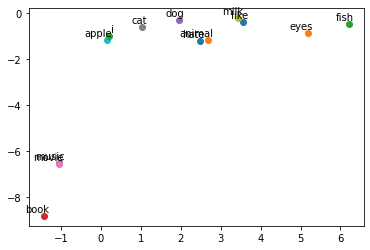

In [19]:
for i, w in int2vocab.items():
    vectors = model.state_dict()["in_embed.weight"]
    x,y = float(vectors[i][0]),float(vectors[i][1])
    plt.scatter(x,y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()